In [1]:
import warnings
# warnings.filterwarnings('ignore')
#
from datetime import datetime, timedelta
import iris
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd
import string
# My packages
import arke
# Local scripts
import mypaths
from horiz_cross import prepare_data
from plot_utils import plotter, map_kw, LCC_KW, AXGR_KW, mstart_kw, mfin_kw
from um_cube_params import CUBE_PARAMS
import misc_utils as misc
from common_defs import fcst_strs, hours, pl_cases, um_res

In [2]:
from tqdm import tqdm # _notebook as tqdm

In [13]:
plt.style.use('./paperfig.mplstyle')

## Input data

In [3]:
level_dict = {'vort': {'value': 950.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
#               'quiver': {'value': 950.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
              'pv': {'value': 500.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
              'slp': {'name': '', 'subdir': 'sfc'},
              'orog': {'name': '', 'subdir': 'sfc'},
              'seaice': {'name': '', 'subdir': 'sfc'}}
# level_dict = {
# #               'rv': {'value': 950.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
#               'thetae': {'value': 850.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
#               'quiver': {'value': 850.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
# #               'pv': {'value': 500.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
#               'slp': {'name': '', 'subdir': 'sfc'},
#               'orog': {'name': '', 'subdir': 'sfc'},
#               'seaice': {'name': '', 'subdir': 'sfc'}}
# level_dict = {'lwtoa': {'name': '', 'subdir': 'sfc'},
#               'precip': {'name': '', 'subdir': 'sfc'},
#               'slp': {'name': '', 'subdir': 'sfc'},
#               'seaice': {'name': '', 'subdir': 'sfc'},
#               'orog': {'name': '', 'subdir': 'sfc'}
#              }
subdirs = {i['subdir'] for i in level_dict.values()}
varnames = [*level_dict.keys()]

In [4]:
run = 'ctrl'

In [5]:
list_of_cubelists = []
for fcst in tqdm(fcst_strs):
    _joint_cubelist = iris.cube.CubeList()
    for subdir in subdirs:
        input_path = mypaths.PATH_MASK.format(um_res=um_res,
                                              fcst_init=fcst,
                                              idir=run,
                                              subdir=subdir)
        cubelist = iris.load(input_path,
                             callback=arke.io.clean_call)
        for cube in cubelist:
            add_attr = dict(subdir=subdir,
                            run=run,
                            um_res=um_res)
            cube.attributes.update(add_attr)
        _joint_cubelist += cubelist
    list_of_cubelists.append(_joint_cubelist)

100%|██████████| 2/2 [01:20<00:00, 41.01s/it]


In [6]:
h_subset = dict(method='rim', width=24)

In [7]:
vrbls2plot = dict()
for cubelist, (pl_case, fcst_str) in zip(list_of_cubelists, pl_cases.items()):
    vrbls2plot[fcst_str] = []
    for hour in hours[pl_case]:
        idt = datetime.strptime(fcst_str, '%Y%m%dT%H%MZ') + timedelta(hours=hour)
    
        vrbls2plot[fcst_str].append(iris.cube.CubeList(prepare_data(cubelist, varnames,
                                                       idt, level_dict, h_subset)))

In [8]:
runs = [run]
tracks = {}
for fcst in pl_cases.values():
    tracks[fcst] = {}
    for run in runs:
        input_dir = mypaths.trackdir / fcst / run
        tracks[fcst][run] = pd.read_csv(input_dir / f'pl_loc.{fcst}.{um_res}.{run}.vort_mslp.txt', parse_dates=[0])

In [9]:
pe = [PathEffects.withStroke(linewidth=5, foreground='k')]

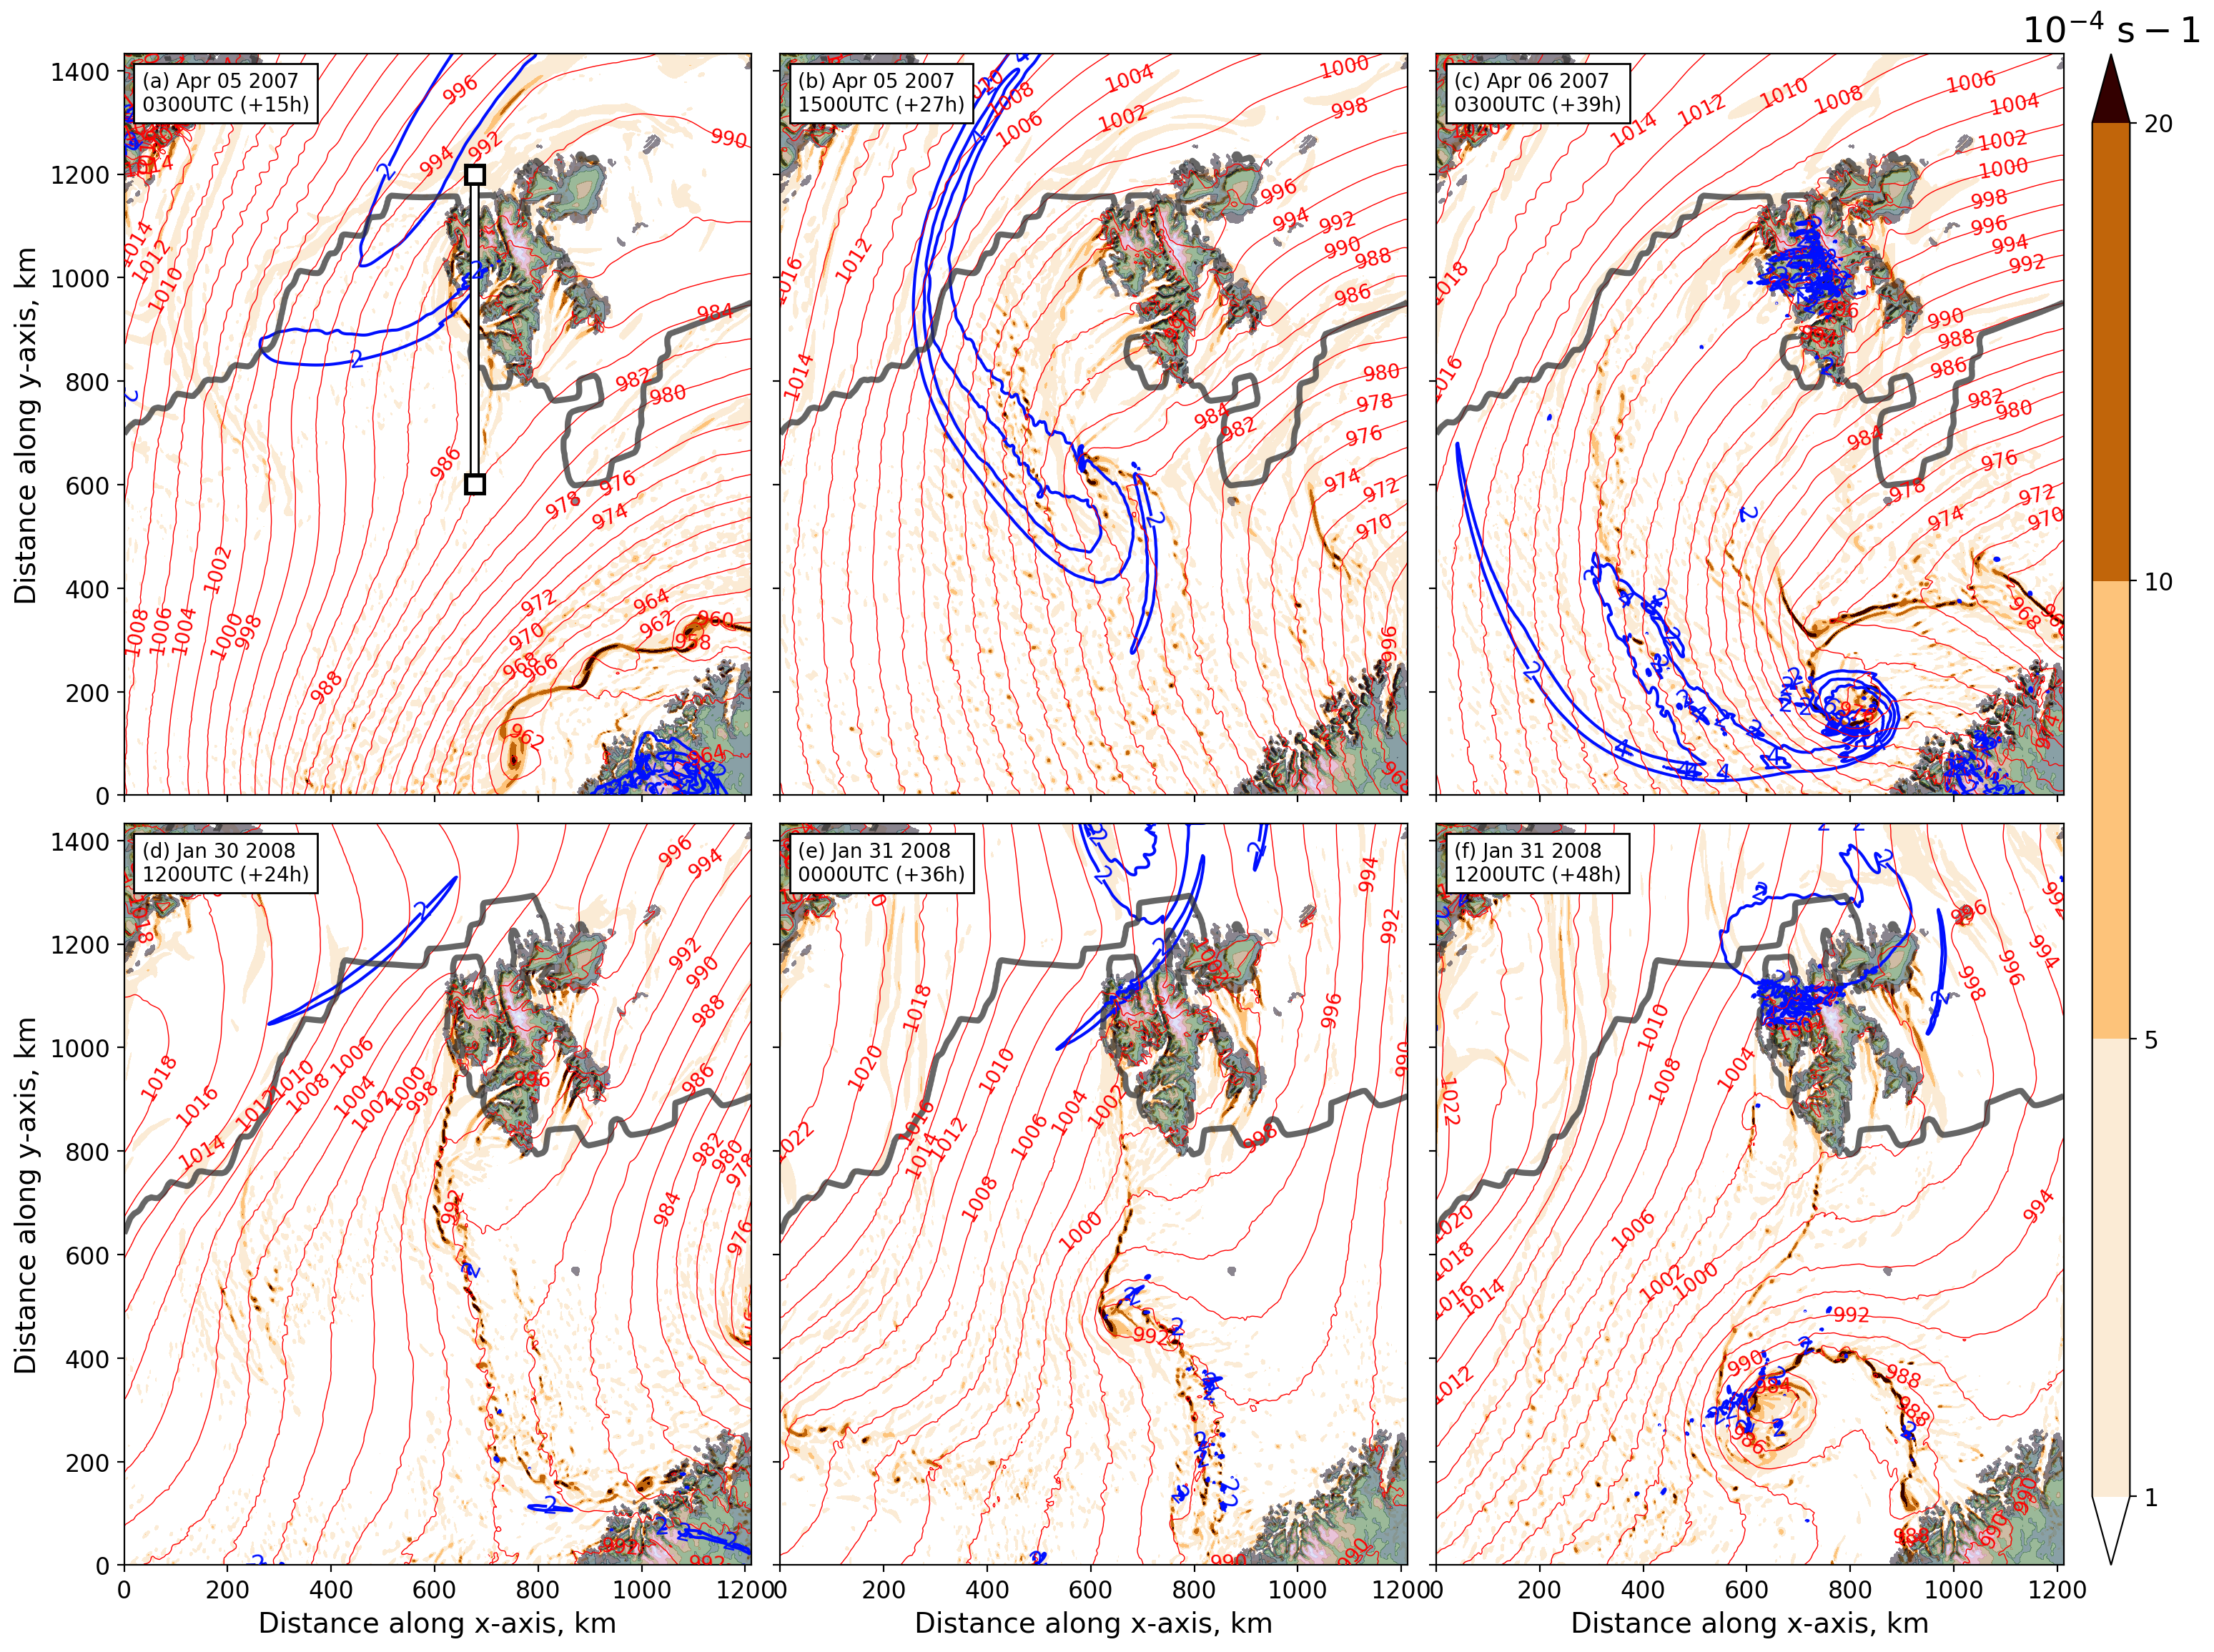

In [14]:
ncol = len(hours['STARS72'])
nrow = len(pl_cases)
fig = plt.figure(figsize=(ncol*7, nrow*7))

# axgr = arke.cart.lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)
axgr = AxesGrid(fig, 111, (nrow, ncol), **AXGR_KW)

plotter(fig, axgr, {}, vrbls2plot, geoax=False)

span_km = 300
# for ax, hour in zip(axgr.axes_all, hours['STARS72']):
ax = axgr.axes_all[0]
hour = hours['STARS72'][0]
fcst = pl_cases['STARS72']
track = tracks[fcst]['ctrl']

idt = datetime.strptime(fcst, '%Y%m%dT%H%MZ') + timedelta(hours=hour)
_, lon, lat = track.loc[track['time'] == idt].values[0]
iy, ix = arke.grid.nearest_xy_grid_2d_index(vrbls2plot[fcst][0][0], lon, lat)

dx = round(span_km / um_res.to_flt('km'))

pnts = dict(x=np.asarray((ix, ix)),
            y=np.asarray((iy-dx, iy+dx)))

ax.plot(pnts['x']*um_res.to_flt('km'), pnts['y']*um_res.to_flt('km'),
        linewidth=3, color='w', marker='s',
        path_effects=pe);

In [15]:
lev_str = ''
for vrbl in varnames:
    if 'value' in level_dict[vrbl]:
        lev_str += f'{vrbl}{level_dict[vrbl]["value"]:.0f}{level_dict[vrbl]["unit"]}_'
    else:
        lev_str += f'{vrbl}_'
lev_str = lev_str.rstrip('_')

In [16]:
fig.savefig(mypaths.plotdir / f'overview_{lev_str}')